<img src="https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png" alt="InvertedAI" width="200"/>


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(0, "..")

import IPython
from IPython.display import display, Image, clear_output
from ipywidgets import interact

import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2 
import invertedai as iai
from IPython.utils import io
import time

http://0.0.0.0:8001


In [4]:
# API key:
# iai.add_apikey("")

In [5]:
# pick a location (4 way, signalized intgersection)
location = "iai:drake_street_and_pacific_blvd"

In [6]:
location_info_response = iai.location_info(location=location)
rendered_static_map = location_info_response.birdview_image.decode()
scene_plotter = iai.utils.ScenePlotter(rendered_static_map, 
                                       location_info_response.map_fov, 
                                       (location_info_response.map_center.x, location_info_response.map_center.y), 
                                       location_info_response.static_actors)
# location_info_response.map_fov, 

# get traffic light states
light_response = iai.light(location=location)

# initialize the simulation by spawning NPCs
response = iai.initialize(
    location=location,  # select one of available locations
    agent_count=25,    # number of NPCs to spawn
    get_birdview=True,  # provides simple visualization - don't use in production
    traffic_light_state_history=[light_response.traffic_lights_states]  # provide traffic light states
)
agent_attributes = response.agent_attributes  # get dimension and other attributes of NPCs
scene_plotter.initialize_recording(response.agent_states, 
                                   agent_attributes=agent_attributes, 
                                   traffic_light_states=light_response.traffic_lights_states)


images = [response.birdview.decode()]  # images storing visualizations of subsequent states
agent_state_history = []
traffic_light_state_history = []

for _ in range(200):  # how many simulation steps to execute (10 steps is 1 second)

    # get next traffic light state
    light_response = iai.light(location=location, recurrent_states=light_response.recurrent_states)

    # query the API for subsequent NPC predictions
    response = iai.drive(
        location=location,
        agent_attributes=agent_attributes,
        agent_states=response.agent_states,
        recurrent_states=response.recurrent_states,
        get_birdview=True,
        traffic_lights_states=light_response.traffic_lights_states,
        get_infractions=True,
        random_seed=1
    )
    scene_plotter.record_step(response.agent_states, traffic_light_states=light_response.traffic_lights_states);
    agent_state_history.append(response.agent_states)
    traffic_light_state_history.append(light_response.traffic_lights_states)

In [7]:
# %%capture
# gif_name = 'iai-drive-side-road-green.gif'
# fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
# scene_plotter.animate_scene(output_name=gif_name, ax=ax,
#                             numbers=False, direction_vec=False, velocity_vec=False,
#                             plot_frame_number=True)

In [8]:
# Image(gif_name)

In [9]:
blame_response = iai.blame(
    location=location,
    candidate_agents=[0, 0],
    agent_state_history=agent_state_history,
    agent_attributes=agent_attributes,
    traffic_light_state_history=traffic_light_state_history,
    get_birdview=True,
    detect_collisions=True
)
print(blame_response.blamed_collisions)

[((3, 23), (96, 99), (3,)), ((7, 20), (8, 18), (7, 20)), ((18, 23), (111, 117), (18, 23)), ((21, 23), (130, 143), (21,))]


In [25]:
blame_response = iai.blame(
    location=location,
    candidate_agents=[21, 23],
    agent_state_history=agent_state_history[:143],
    agent_attributes=agent_attributes,
    traffic_light_state_history=traffic_light_state_history[:143],
    get_reason=True,
    get_confidence_score=True,
    get_birdview=True,
    detect_collisions=False
)
print(blame_response.blamed_result)

(23,)


In [26]:
blame_response.reason

'rear_end'

In [27]:
blame_response.confidence_score

0.5407472252845764

In [28]:
%%capture
fig, ax = plt.subplots(constrained_layout=True, figsize=(15, 15))
gif_name = 'part-iai-drive-side-road-green.gif'
scene_plotter.animate_scene(output_name=gif_name, ax=ax, 
                            start_idx=110, end_idx=143,
                            numbers=[21, 23], direction_vec=False, velocity_vec=False,
                            plot_frame_number=True)

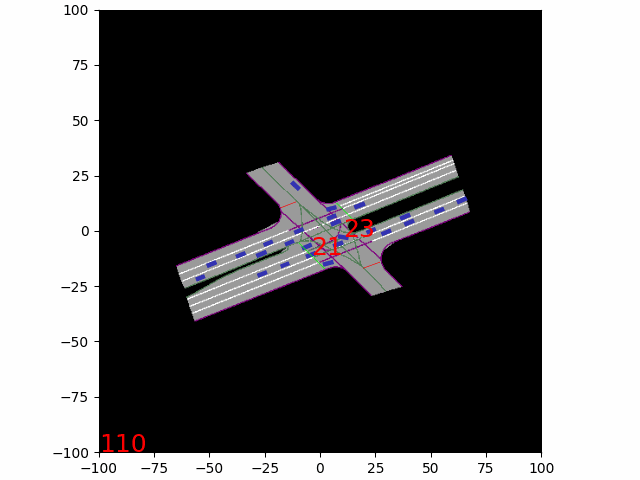

In [29]:
Image(gif_name)